In [1]:
#import libraries

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster
from fastcluster import linkage
import seaborn as sns
import scipy.cluster.hierarchy as sch
from matplotlib import cm
import plotly.figure_factory as ff
from scipy.spatial import ConvexHull
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import glob
from scipy.cluster.hierarchy import linkage, fcluster
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import seaborn as sns
import numpy as np

In [2]:
import pandas as pd
import glob

# set paths to folders containing CSV files
path = "C:/DSGP/Data_Challenge_PHM2022_training_data/Data_Challenge_PHM2022_training_data/"

# combine data_po files into df1
files_po = glob.glob(path + "*data_po*.csv")
df1 = pd.DataFrame()
for file in files_po:
    with open(file, 'r') as f:
        csv_string = f.read()

        data = csv_string
        df = pd.DataFrame([x.split(',') for x in data.split('\n')])
        df.drop(df.tail(1).index,inplace=True)

        temp_df = df.iloc[:, :500]
        df1 = pd.concat([df1, temp_df], axis=0)

# rename the columns in df1 and convert to float
df1.columns = [i for i in range(df1.shape[1])]
df1 = df1.rename(columns={0: 'Fault'})
df1 = df1.astype(float)

# combine data_pdmp files into df2
files_pdmp = glob.glob(path + "*data_pdmp*.csv")
df2 = pd.DataFrame()
for file in files_pdmp:
    with open(file, 'r') as f:

        csv_string = f.read()

        data = csv_string
        df = pd.DataFrame([x.split(',') for x in data.split('\n')])
        df.drop(df.tail(1).index,inplace=True)

        temp_df = df.iloc[:, :500]
        df2 = pd.concat([df2, temp_df], axis=0)

# rename the columns in df2 and convert to float
df2.columns = [i for i in range(df2.shape[1])]
df2 = df2.rename(columns={0: 'Fault'})
df2 = df2.astype(float)

# combine data_pin files into df3
files_pin = glob.glob(path + "*data_pin*.csv")
df3 = pd.DataFrame()
for file in files_pin:
    with open(file, 'r') as f:

        csv_string = f.read()

        data = csv_string
        df = pd.DataFrame([x.split(',') for x in data.split('\n')])
        df.drop(df.tail(1).index,inplace=True)

        temp_df = df.iloc[:, :500]
        df3 = pd.concat([df3, temp_df], axis=0)

# rename the columns in df3 and convert to float
df3.columns = [i for i in range(df3.shape[1])]
df3 = df3.rename(columns={0: 'Fault'})
df3 = df3.astype(float)


In [3]:
# Assign Fault labels (true values) to new df y_true

y_true1 = df1["Fault"]
y_true2 = df2["Fault"]
y_true3 = df3["Fault"]

In [4]:
# del fault label column to get unlabelled df1, df2, df3

df1.columns = df1.columns.astype(str)
df1_un = df1.drop(df1.columns[0], axis=1)

df2.columns = df2.columns.astype(str)
df2_un = df2.drop(df2.columns[0], axis=1)

df3.columns = df3.columns.astype(str)
df3_un = df3.drop(df3.columns[0], axis=1)

# df1_un ... are unlabelled dfs

In [5]:
# Perform PCA and set components

# set number of pca components
n_components = 3

pca = PCA(n_components)

principal_components1 = pca.fit_transform(df1_un)
principal_components2 = pca.fit_transform(df2_un)
principal_components3 = pca.fit_transform(df3_un)

In [6]:
# Create a DataFrame df_pca with the principal components

df_pca1 = pd.DataFrame(data=principal_components1, index=df1.index)
df_pca2 = pd.DataFrame(data=principal_components2, index=df2.index)
df_pca3 = pd.DataFrame(data=principal_components3, index=df3.index)

In [7]:
# Perform Hierarchial means clustering and assign new column 'cluster' with cluster label to df

def hr_pca(df_list, num_clusters):
    for index, df in enumerate(df_list):
        linkage_matrix = linkage(df, method='ward')
        cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
        df['cluster'] = cluster_labels

# set df list and number of clusters
hr_pca([df_pca1, df_pca2, df_pca3], num_clusters=11)

# Each row is now assigned a cluster label

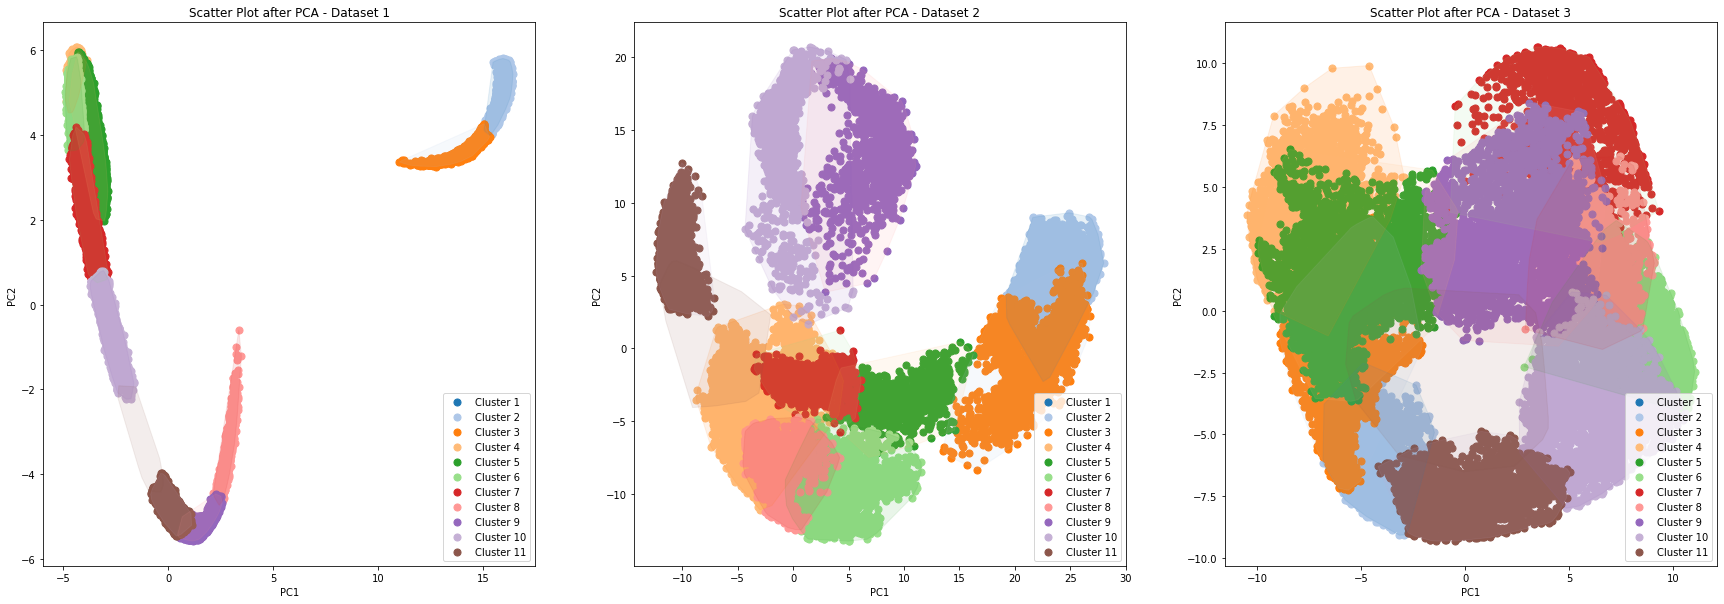

In [12]:
# Plot clusters againts first two PCA components 

def plot_clusters(df_list, num_clusters):
    # Create a list of unique colors for each cluster
    colors = sns.color_palette('tab20', num_clusters)
    fig, axs = plt.subplots(1, len(df_list), figsize=(10*len(df_list), 10))

    # Create a separate scatter plot for each dataframe
    for j, df in enumerate(df_list):
        ax = axs[j]
        for i in range(num_clusters):
            ax.scatter(df.loc[df['cluster']==i, 0], df.loc[df['cluster']==i, 1], color=colors[i], s=50, label=f'Cluster {i+1}')
            ax.set_title(f'Scatter Plot after PCA - Dataset {j+1}')
            ax.set_xlabel('PC1')
            ax.set_ylabel('PC2')
            ax.legend(loc='lower right')

        # Draw convex hulls
        for i in range(np.unique(df['cluster']).shape[0]):
            cluster_points = df.loc[df['cluster']==i+1, [0, 1]]
            hull = ConvexHull(cluster_points)
            axs[j].fill(cluster_points.iloc[hull.vertices, 0], cluster_points.iloc[hull.vertices, 1], color=colors[i], alpha=0.1)

    plt.show()

# Example usage with three dataframes df1, df2, df3:
plot_clusters([df_pca1, df_pca2, df_pca3], num_clusters=11)

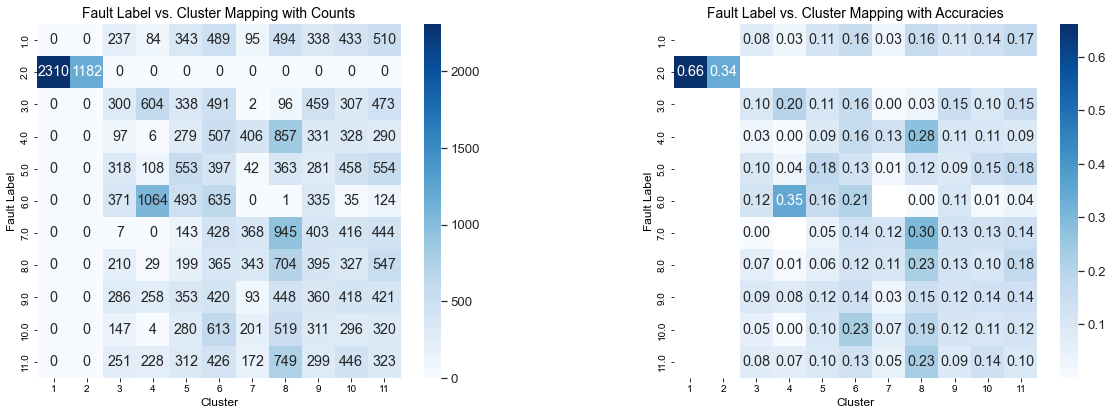

In [13]:
# create a crosstab of true labels and cluster assignments
label_cluster_map = pd.crosstab(y_true1, df_pca1["cluster"])

# calculate the accuracy of each group
grouped = df_pca1.groupby([y_true1, df_pca1["cluster"]])
accuracy = grouped.size() / grouped.size().groupby(level=0).sum()

# create the figure and axes for the subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# plot the heatmap with counts on the left subplot
sns.set(font_scale=1.2)
sns.heatmap(label_cluster_map, cmap='Blues', annot=True, fmt='d', ax=axs[0])
axs[0].set_xlabel('Cluster', fontsize=12)
axs[0].set_ylabel('Fault Label', fontsize=12)
axs[0].set_title('Fault Label vs. Cluster Mapping with Counts', fontsize=14)

# plot the heatmap with accuracies on the right subplot
sns.heatmap(accuracy.unstack(), cmap='Blues', annot=True, fmt='.2f', ax=axs[1])
axs[1].set_xlabel('Cluster', fontsize=12)
axs[1].set_ylabel('Fault Label', fontsize=12)
axs[1].set_title('Fault Label vs. Cluster Mapping with Accuracies', fontsize=14)

# adjust the layout and spacing of the subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)

# display the subplots
plt.show()


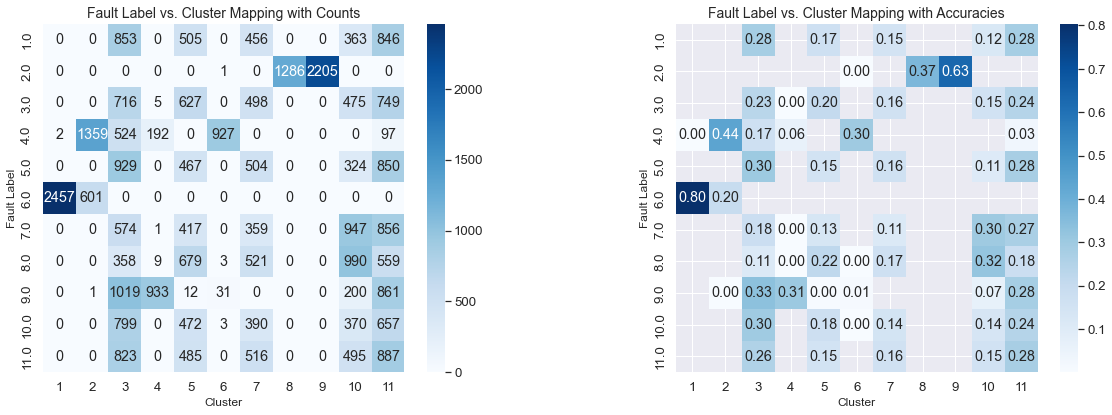

In [14]:
# create a crosstab of true labels and cluster assignments
label_cluster_map = pd.crosstab(y_true2, df_pca2["cluster"])

# calculate the accuracy of each group
grouped = df_pca2.groupby([y_true2, df_pca2["cluster"]])
accuracy = grouped.size() / grouped.size().groupby(level=0).sum()

# create the figure and axes for the subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# plot the heatmap with counts on the left subplot
sns.set(font_scale=1.2)
sns.heatmap(label_cluster_map, cmap='Blues', annot=True, fmt='d', ax=axs[0])
axs[0].set_xlabel('Cluster', fontsize=12)
axs[0].set_ylabel('Fault Label', fontsize=12)
axs[0].set_title('Fault Label vs. Cluster Mapping with Counts', fontsize=14)

# plot the heatmap with accuracies on the right subplot
sns.heatmap(accuracy.unstack(), cmap='Blues', annot=True, fmt='.2f', ax=axs[1])
axs[1].set_xlabel('Cluster', fontsize=12)
axs[1].set_ylabel('Fault Label', fontsize=12)
axs[1].set_title('Fault Label vs. Cluster Mapping with Accuracies', fontsize=14)

# adjust the layout and spacing of the subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)

# display the subplots
plt.show()


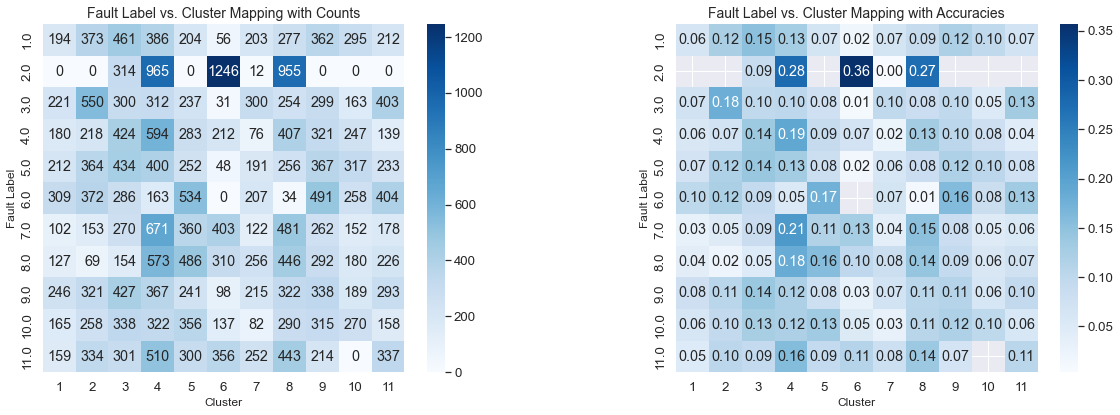

In [15]:
# create a crosstab of true labels and cluster assignments
label_cluster_map = pd.crosstab(y_true3, df_pca3["cluster"])

# calculate the accuracy of each group
grouped = df_pca3.groupby([y_true3, df_pca3["cluster"]])
accuracy = grouped.size() / grouped.size().groupby(level=0).sum()

# create the figure and axes for the subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# plot the heatmap with counts on the left subplot
sns.set(font_scale=1.2)
sns.heatmap(label_cluster_map, cmap='Blues', annot=True, fmt='d', ax=axs[0])
axs[0].set_xlabel('Cluster', fontsize=12)
axs[0].set_ylabel('Fault Label', fontsize=12)
axs[0].set_title('Fault Label vs. Cluster Mapping with Counts', fontsize=14)

# plot the heatmap with accuracies on the right subplot
sns.heatmap(accuracy.unstack(), cmap='Blues', annot=True, fmt='.2f', ax=axs[1])
axs[1].set_xlabel('Cluster', fontsize=12)
axs[1].set_ylabel('Fault Label', fontsize=12)
axs[1].set_title('Fault Label vs. Cluster Mapping with Accuracies', fontsize=14)

# adjust the layout and spacing of the subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)

# display the subplots
plt.show()
